In [1]:
import shelve
import re
import os
from predict_price_helpers import *

In [2]:
with shelve.open('./predict-price.shelve', flag='r') as slf:
    for k,v in slf.items():
        print(k)
        globals()[k] = v
        if re.match('def\d+:', k) is not None:
            print(v)
            exec(v)

RESULTS_DIR
def0:
do_save = lambda fn: not(os.path.isfile(fn))
cfg
num_columns
cat_columns
models
df


In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [4]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

# Model: MLR regularized

As [previous model](#pred_model_6), but use regularization by using built-in Lasso

## Prepare input

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

model_name = 'MLR Lasso'

cat_columns_reduced = list(np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(9932, 29)
(9932,)


## Determine regularization rate (alpha)

Alpha is the hyperparameter that needs to be determined. For this the data needs to be splitted, but the dataset is too small to do a 3 way split (i.e. CV, Train, Test). Therefor spilt 2 way k-fold cv 
- **Test**: Hold-out set for calculating performance
- **Train**: Use to fit model and do CV


In [6]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(6952, 29)
(2980, 29)


In [7]:
# Create model (same as MLR with cats, but regressor is Lasso)

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, pd.Index(num_columns)),
    ('categorical', cat_transformer, pd.Index(cat_columns_reduced)),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=False)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.Lasso(random_state=42, max_iter=2**11)
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=np.log10,
    inverse_func=pow10,
    #inverse_func=lambda y: 10**y
)



In [8]:
def gs_lasso_alpha(pipeline):
    # grid search estimator
    grid_search_alpha = GridSearchCV(
        estimator=pipeline,
        param_grid=[
            {
                'regressor__lasso__alpha': 10**(np.linspace(-4,-2,9)) # Choose alphas such that a clear peaked graph is shown in next plot
            } 
        ],
        cv=8,
        scoring='r2',
        #n_jobs=-1,
        verbose=10
    )

    # Perform grid search
    grid_search_alpha.fit(X_train,y_train);
    
    return grid_search_alpha

In [9]:
def plot_gscv_result(gscv, param_name = None):
    '''
    plot search results    
    '''
    
    if param_name is None:
        param_name = re.sub('^.+?__', '', list(gscv.param_grid[0].keys())[0])
    
    plt.figure(figsize=[2,2])

    # abscissa
    alphas = list(gscv.cv_results_['param_regressor__' + param_name])

    # plot mean
    r2_mean = gscv.cv_results_['mean_test_score']
    # normalize
    r2_mean = (r2_mean-r2_mean.mean())/r2_mean.std()
    plt.plot(alphas, r2_mean, label='mean', lw=4, color='blue')

    # plot folds
    for fold in range(gscv.cv):
        r2_fold = gscv.cv_results_['split{:.0f}_test_score'.format(fold)]
        # normalize
        r2_fold = (r2_fold-r2_fold.mean())/r2_fold.std()
        plt.plot(alphas, r2_fold, label='fold ' + str(fold), lw=1, color='black')

    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('standardized r2 score [a.u.]')
    plt.axvline(gscv.best_params_['regressor__' + param_name], linewidth=2, linestyle='--', color='k')
    result = 'grid search results\nbest {:s}={:.5f}'.format(param_name, gscv.best_params_['regressor__' + param_name])
    plt.title(result)
    print(result)
    plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1,0.5))
    
    return gscv.best_estimator_

### Fit with regressor found with grid search

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV 1/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 1/8; 1/9] END regressor__lasso__alpha=0.0001;, score=0.453 total time=   0.7s
[CV 2/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 2/8; 1/9] END regressor__lasso__alpha=0.0001;, score=0.563 total time=   0.8s
[CV 3/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 3/8; 1/9] END regressor__lasso__alpha=0.0001;, score=0.441 total time=   0.8s
[CV 4/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 4/8; 1/9] END regressor__lasso__alpha=0.0001;, score=0.557 total time=   0.9s
[CV 5/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 5/8; 1/9] END regressor__lasso__alpha=0.0001;, score=0.769 total time=   0.8s
[CV 6/8; 1/9] START regressor__lasso__alpha=0.0001..............................
[CV 6/8; 1/9] END regressor__lasso__alpha=0.

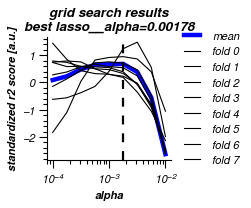

In [10]:
best_estimator = plot_gscv_result(gs_lasso_alpha(pl))

In [11]:
# Store estimator with best alpha
reg = best_estimator
models[model_name].update({'model':reg})

# fit
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [reg.regressor_.steps[-1][1].intercept_, *reg.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})
models[model_name].update({'n betas effective':(np.abs(betas) > 0).sum()})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

In [12]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]

# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first
assert cat_betas[-1][-1] == betas[-1] # last

/home/tom/bin/satdatsci/Saturday-Datascience/results/MLR_Lasso.png


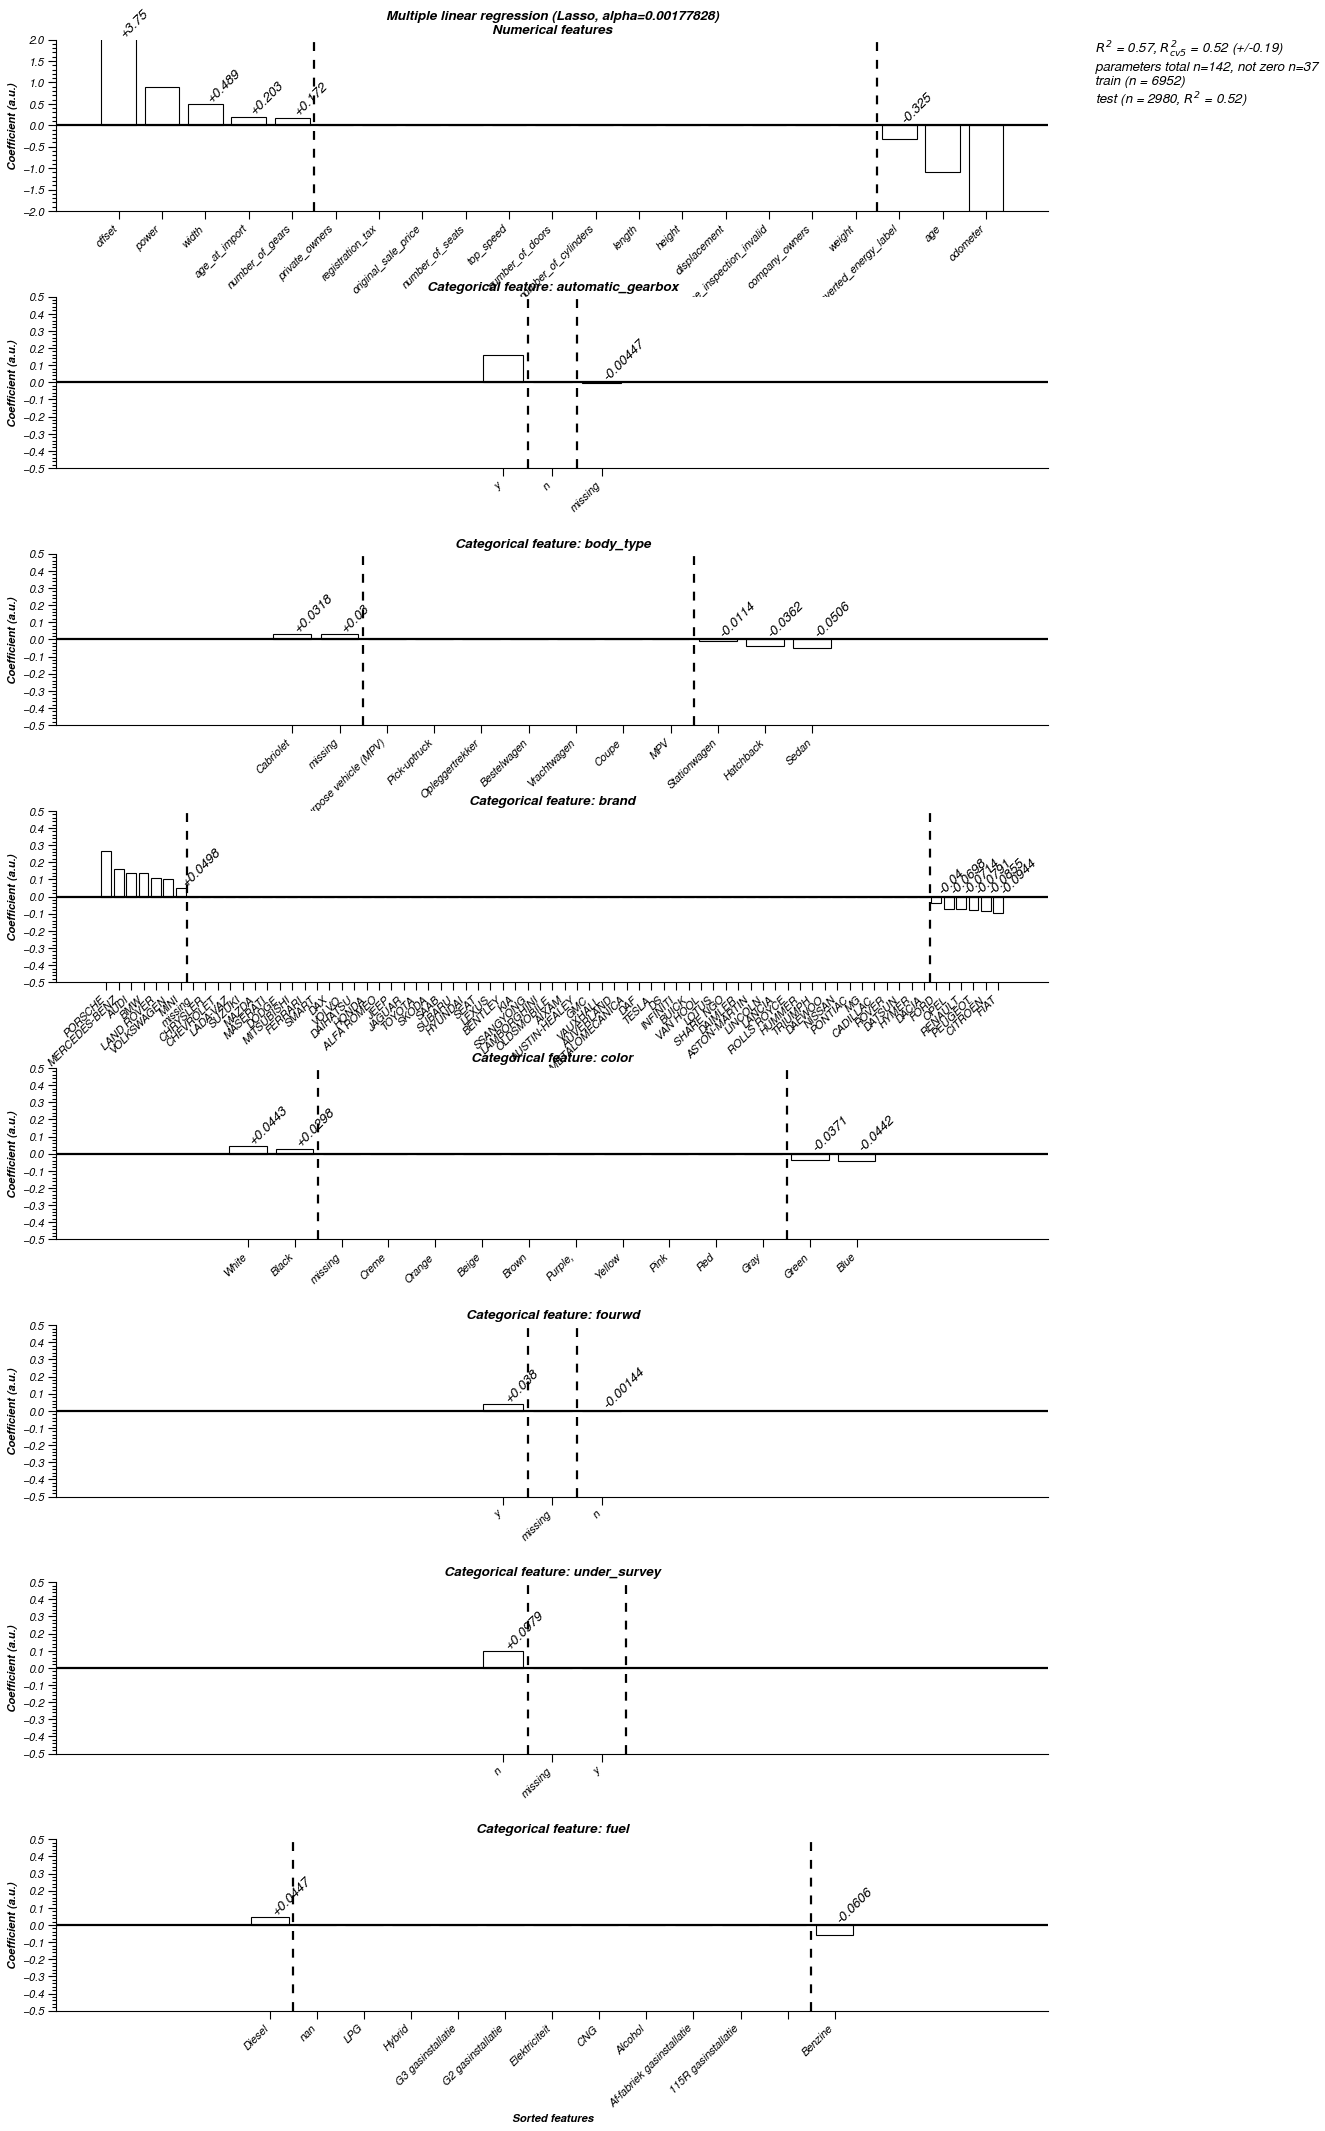

In [13]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[16,4*n_plots]
)
plt.subplots_adjust(hspace=0.5)

# Plot coefficients
for feats, coefs, name, ax in zip(
    [['offset'] + features] + cats,
    [[betas[0]] + betas[1:len(num_columns)+1]] + cat_betas,
    ['numerical'] + cat_columns_reduced,
    axs
):
    # sort by bar height
    x = [feats[i] for i in np.argsort(coefs)[::-1]]
    y = sorted(coefs, reverse=True)
    # plot bar
    ax.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

    # prettify
    if not name.startswith('num'):
        ax.set_yticks(np.arange(-0.5,+0.6,0.1))
        bot_tick, top_tick = ax.set_ylim(top=+0.5, bottom=-0.5)
    else:
        ax.set_yticks(np.arange(-2,2.2,0.5))
        bot_tick, top_tick = ax.set_ylim(top=+2, bottom=-2)
        # stats
        xy=[ax.get_xlim()[1], ax.get_ylim()[1]]
        ax.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
            models[model_name]['R^2'],
            models[model_name]['cv R^2'].shape[0],
            np.mean(models[model_name]['cv R^2']),
            np.std(models[model_name]['cv R^2']),
        ) + '\n' +
                 'parameters total n={}, not zero n={}\n'.format(len(betas), sum(np.array(betas) != 0)) +
                 'train (n = {})'.format(y_train.shape[0]) + '\n' +
                 'test (n = {}, $R^2$ = {:.2f})'.format(
                     y_test.shape[0],
                     models[model_name]['test R^2'],
                 ), style='italic', va='top', ha='left')


    # plot sign switch
    x_sign_switch1 = np.nonzero(np.array(y+[-np.inf]) < 0)[0][0]
    x_sign_switch2 = np.nonzero(np.array([+np.inf]+y) > 0)[0][-1]
    ax.axvline(x_sign_switch1-0.5, linewidth=2, linestyle='--', color='k')
    ax.axvline(x_sign_switch2-0.5, linewidth=2, linestyle='--', color='k')
    ax.axhline(0, linewidth=2, linestyle='-', color='k')

    # add values when bar is small or too large (clipping)
    yt=ax.get_yticks()
    first_tick = sorted(np.abs(yt))[1]
    for x_val, coef in zip(x,y):
        if (coef < first_tick) & (coef > 0):
            ax.text(x_val, coef, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif (coef > -first_tick) & (coef < 0):
            ax.text(x_val, 0, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef > top_tick:
            # generally this is offset (bias)
            ax.text(x_val, top_tick, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef < bot_tick:
            ax.text(x_val, bot_tick, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')

    
    # labels and titles
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticks(x)
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    if not name.startswith('num'):
        ax.set_title('Categorical feature: ' + name, style='italic')
    else:
        ax.set_title('Multiple linear regression (Lasso, alpha={:g})\nNumerical features'.format(
            reg.regressor_.named_steps['lasso'].alpha
        ), style='italic') 
    ax.set_ylabel('Coefficient (a.u.)', style='italic')
    
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 20:
        add_space = len(x) - 20
        xl = list(ax.get_xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        ax.set_xlim(xl)

# Label on bottom panel
ax = axs[-1]
ax.set_xlabel('Sorted features', style='italic')

# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

In [14]:
fn = './predict-price.shelve'
with shelve.open(fn, flag='w') as slf:
    slf['models'] = models 
    print(f'Shelve file [{fn}] contains models:')
    for m in slf['models'].keys():
        print(f'\t{m}')

Shelve file [./predict-price.shelve] contains models:
	linear regression no cv
	linear regression log price young
	MLR reduced observations
	MLR impute median
	MLR with categorical
	MLR Lasso
